In [48]:
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from datetime import datetime
import tensorflow as tf

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_19670/3878954045.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [62]:
#clean up data for
data = pd.read_csv('full_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

eth = data.loc[data['Crypto']=='ETH']
eth = eth.drop('Unnamed: 0', axis=1)
eth = eth.sort_values(by='Date')
eth = eth.reset_index(drop=True)
eth = eth.drop(['Crypto'],axis=1)
eth = eth.set_index('Date')

eth = eth.loc[eth.index<=datetime(2022,5,31)]

In [64]:
def calculate_rsi(prices, window=50):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=50).mean()
    avg_loss = loss.rolling(window=window, min_periods=50).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(df, window=50):
    df['Returns'] = df['Close'].pct_change()    
    df['MovingAverage'] = df['Close'].rolling(window=50).mean()
    df['Volatility'] = df['Returns'].rolling(window=50).std() * np.sqrt(50)
    df['RSI'] = calculate_rsi(df['Close'])

    # Creating the momentum feature
    df['Momentum'] = df['Close'] - df['MovingAverage']
    df['Momentum'] /= df['MovingAverage'] * df['Volatility']

    # Droping features which the function should not append
    df = df.drop(columns=['MovingAverage'])
    df = df.dropna()

    return df


eth = transform_prices(eth)

In [65]:
#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X
# Forecasting target t+n days ahead
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps + target_steps - 1]
                  for idx in range(n_obs)])
    return y

In [66]:
value_features = 50 #we use last 60 days 
value_target = 5 #to forecast 5 days ahead
#split the data for all 3 assets
eth_open = ts_split(np.array(eth['Open']), feature_steps = value_features, target_steps = value_target)
eth_high = ts_split(np.array(eth['High']), feature_steps = value_features, target_steps = value_target)
eth_low = ts_split(np.array(eth['Low']), feature_steps = value_features, target_steps = value_target)
eth_close = ts_split(np.array(eth['Close']), feature_steps = value_features, target_steps = value_target)
eth_ret = ts_split(np.array(eth['Returns']), feature_steps = value_features, target_steps = value_target)
eth_vol = ts_split(np.array(eth['Volatility']), feature_steps = value_features, target_steps = value_target)
eth_rsi = ts_split(np.array(eth['RSI']), feature_steps = value_features, target_steps = value_target)
eth_mom = ts_split(np.array(eth['Momentum']), feature_steps = value_features, target_steps = value_target)

#Target var of predicting price t+n days ahead
y_eth = ts_split_y(np.array(eth['Close']), feature_steps = value_features, target_steps = value_target)

In [67]:
#create the features matrix
combined_array = np.stack((eth_open, eth_high , eth_low, eth_close, eth_ret, eth_vol, eth_rsi, eth_mom), axis=1)
X = combined_array

In [68]:
# Determine the size of the validation set
train_idx = round(len(X)*0.8)
X_train_full= X[:train_idx] ## all same for each model

#test data for X and y targets
X_test= X[train_idx:]
y_test_eth = y_eth[train_idx:]

val_idx = round(train_idx * 0.1)  # 10% of the training set
train_idx_final = train_idx - val_idx

# Split the training data into training and validation sets
X_train = X_train_full[:train_idx_final]
X_val = X_train_full[train_idx_final:train_idx]

#train and validation for targets
y_train_eth = y_eth[:train_idx_final]
y_val_eth = y_eth[train_idx_final:train_idx]

#reshape and convert all into pandas series
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped = pd.DataFrame(X_train_reshaped)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = pd.DataFrame(X_val_reshaped)

y_train_eth = pd.DataFrame(y_train_eth)
y_val_eth = pd.DataFrame(y_val_eth)

#reshape  test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_reshaped = pd.DataFrame(X_test_reshaped)

y_test_eth_reshaped = y_test_eth.reshape(y_test_eth.shape[0], -1)
y_test_eth_reshaped = pd.DataFrame(y_test_eth_reshaped)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
initializer = HeNormal()

# Function to reset the TensorFlow session
def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Reset the session
    # Reset the session
reset_session()
nuerons = 73
activation = "swish"
l2_reg = 0.30538342190212675
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_reshaped.shape[1:])

# Define the DNN model
model = Sequential([
    norm_layer,
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(1)
])
optimizer = Nadam(learning_rate=0.00011631756169915276)
model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

# Train the model
history = model.fit(X_train_reshaped, y_train_eth, epochs=100, validation_data=(X_val_reshaped, y_val_eth))
y_test_pred = model.predict(X_test_reshaped)
#prediction_accuracy = np.mean(np.sign(pd.DataFrame(y_test_pred).diff().dropna()) == np.sign(pd.DataFrame(y_test_eth).diff().dropna()))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 108880048.0000 - mse: 108878400.0000 - val_loss: 1891454.5000 - val_mse: 1889822.1250
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47486.7930 - mse: 45866.1953 - val_loss: 1661772.7500 - val_mse: 1660187.7500
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40707.1016 - mse: 39133.4922 - val_loss: 1408706.6250 - val_mse: 1407167.1250
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29827.2656 - mse: 28298.7168 - val_loss: 1168953.8750 - val_mse: 1167457.8750
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25000.4609 - mse: 23515.0059 - val_loss: 792437.1875 - val_mse: 790982.8750
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24019.6797 - mse: 22575.4961 - val_loss: 971814.6250 - val_mse: 970400.4375
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16832.4336 - mse: 15427.8223 - val_loss: 841883.0000 - val_mse: 840506.9375
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


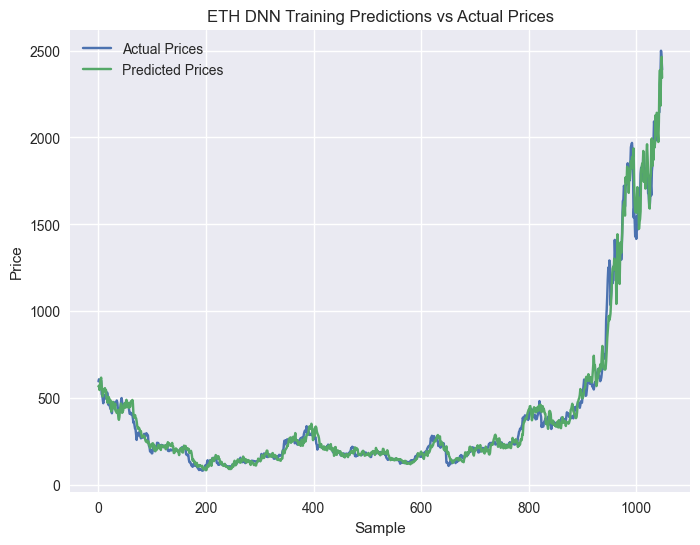

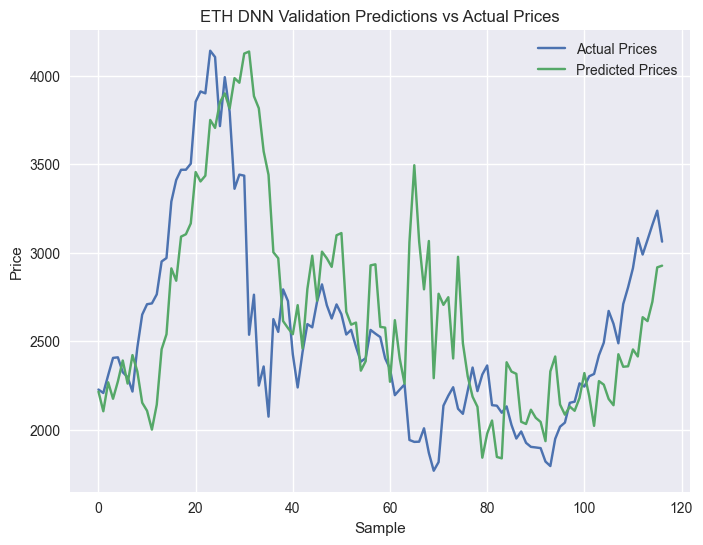

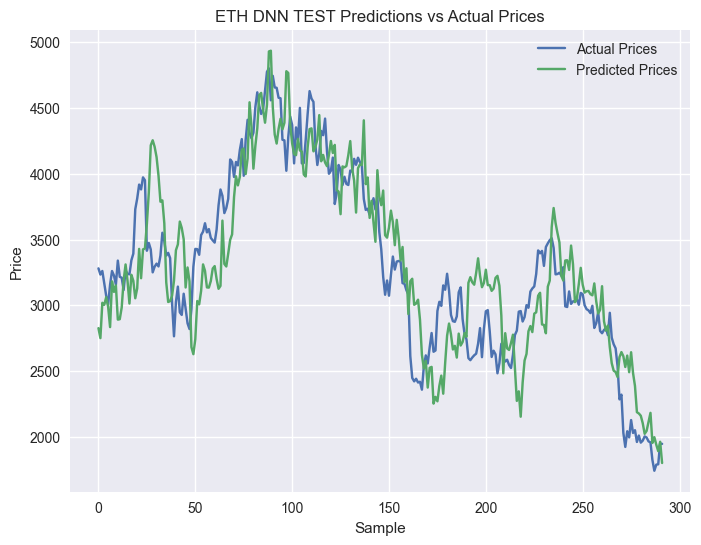

In [75]:
# Make predictions
y_train_pred = model.predict(X_train_reshaped)
y_val_pred = model.predict(X_val_reshaped)
y_test_pred = model.predict(X_test_reshaped)

plt.figure(figsize=(8, 6))
plt.plot(y_train_eth, label='Actual Prices')
plt.plot(y_train_pred, label='Predicted Prices')
plt.title('ETH DNN Training Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.savefig('final_writeup/Images/eth_train_eth.png', dpi=200, bbox_inches='tight')

# Plot the predictions vs actual values for validation set
plt.figure(figsize=(8, 6))
plt.plot(y_val_eth, label='Actual Prices')
plt.plot(y_val_pred, label='Predicted Prices')
plt.title('ETH DNN Validation Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.savefig('final_writeup/Images/eth_validation.png', dpi=200, bbox_inches='tight')

# Plot the predictions vs actual values for validation set
plt.figure(figsize=(8, 6))
plt.plot(y_test_eth, label='Actual Prices')
plt.plot(y_test_pred, label='Predicted Prices')
plt.title('ETH DNN TEST Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.savefig('final_writeup/Images/eth_test.png', dpi=200, bbox_inches='tight')
plt.show()

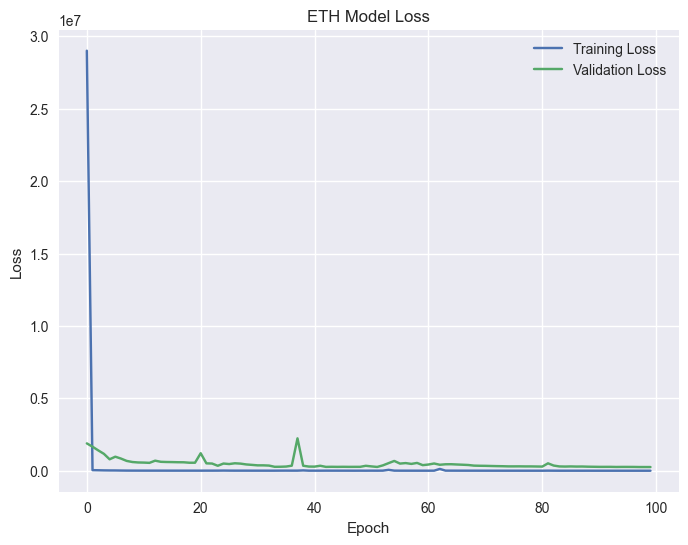

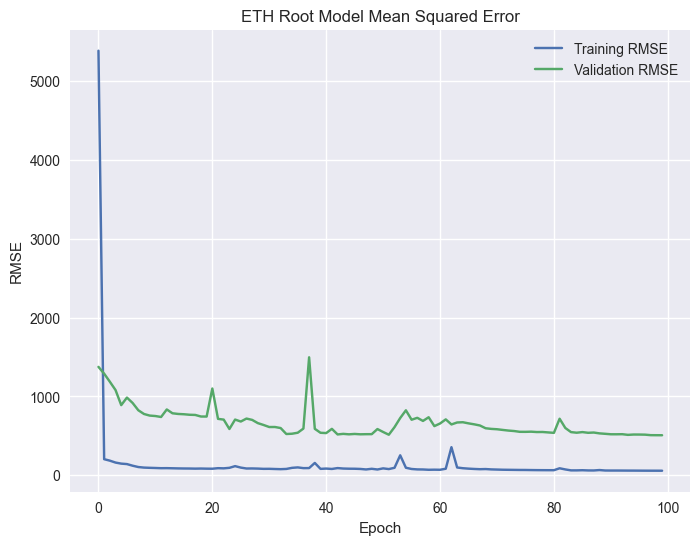

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ETH Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('final_writeup/Images/eth_model_loss.png', dpi=200, bbox_inches='tight')

# Plot training & validation MSE values
plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(history.history['mse']), label='Training RMSE')
plt.plot(np.sqrt(history.history['val_mse']), label='Validation RMSE')
plt.title('ETH Root Model Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.savefig('final_writeup/Images/eth_rmse.png', dpi=200, bbox_inches='tight')
plt.show()

In [77]:
model.save("eth_model_Final.keras")

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Nadam
import keras_tuner as kt
import tensorflow as tf

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=10, max_value=50, default=2)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    l2_reg = hp.Float("l2_reg", min_value=1e-4, max_value=100, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "Nadam", "Adam"])
    activation = hp.Choice("activation", values=["relu", "swish"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train_scaled.shape[1:]))
    model.add(tf.keras.layers.Normalization())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=optimizer,
                  metrics=["RootMeanSquaredError"])
    return model

In [45]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_loss", max_trials=50, overwrite=True,
    directory="ETH", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train_scaled, y_train_eth, epochs=50,
                           validation_data=(X_val_scaled, y_val_eth))

Trial 50 Complete [00h 00m 15s]
val_loss: 714581.5625

Best val_loss So Far: 227981.46875
Total elapsed time: 00h 14m 23s


In [46]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
best_params = top3_params[0].values

print(f"Best hyperparameters: {best_params}")

/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 155 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'n_hidden': 37, 'n_neurons': 73, 'learning_rate': 0.00011631756169915276, 'l2_reg': 0.30538342190212675, 'optimizer': 'Nadam', 'activation': 'swish'}


/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 79 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
